<a href="https://colab.research.google.com/github/khushipr/Parameter_Optimization_of_SVM/blob/main/Parameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Necessary Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

###Uploading the Dataset from UCI Library

In [69]:
uploaded = pd.read_csv('https://raw.githubusercontent.com/unicolour/Parameter_Optimization_Of_SVM/main/DryBeanDataset.csv')

In [70]:
dataset = uploaded
dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


###Pre-Processing of Dataset

In [71]:
dataset.shape

(13611, 17)

In [72]:
dataset.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

In [73]:
# dataset = dataset.drop(['Date','Time'],axis=1)

<AxesSubplot: xlabel='Class', ylabel='count'>

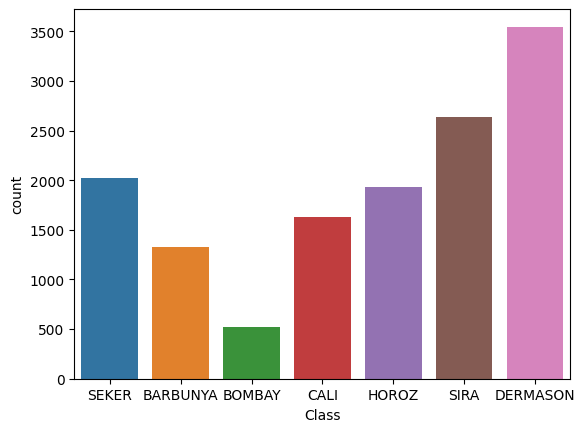

In [74]:
sns.countplot(x = 'Class', data=dataset)

In [75]:
X = dataset.iloc[:,0:-1]
y = dataset['Class']

In [76]:
ss = StandardScaler()
ss.fit_transform(X)

array([[-0.84074853, -1.1433189 , -1.30659814, ...,  2.40217287,
         1.92572347,  0.83837103],
       [-0.82918764, -1.01392388, -1.39591111, ...,  3.10089314,
         2.68970162,  0.77113842],
       [-0.80715717, -1.07882906, -1.25235661, ...,  2.23509147,
         1.84135576,  0.91675514],
       ...,
       [-0.37203825, -0.44783294, -0.45047814, ...,  0.28920441,
         0.33632829,  0.39025114],
       [-0.37176543, -0.42702856, -0.42897404, ...,  0.22837538,
         0.2489734 ,  0.03644001],
       [-0.37135619, -0.38755718, -0.2917356 , ..., -0.12777587,
        -0.2764814 ,  0.71371948]])

###Creation of 10 samples with 70-30 ratio of Training and Testing Set

In [77]:
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    samples.append((X_train, X_test, y_train, y_test))

In [78]:
samples

[(        Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
  10704  27490    618.868       233.001523       151.202562      1.540989   
  13145  37946    738.476       264.960115       182.588263      1.451134   
  2571   67686   1044.470       368.601069       234.202503      1.573856   
  4683   74759   1058.713       405.850888       238.557776      1.701269   
  12624  35110    693.189       254.183543       176.478601      1.440308   
  ...      ...        ...              ...              ...           ...   
  13123  37832    720.476       263.034496       183.384980      1.434330   
  3264   85890   1152.016       417.536420       262.719645      1.589285   
  9845   51131    842.796       316.185620       207.028992      1.527253   
  10799  27884    630.303       239.405409       148.484842      1.612322   
  2732   70344   1037.985       378.651095       237.909773      1.591574   
  
         Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  rou

### Creation of a Fitness Function

In [79]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
result = pd.DataFrame(columns=['Sample', 'Best Accuracy', 'Best Kernel', 'Best Nu', 'Best Epsilon'])

In [80]:
def fitnessFunction(kernel, C, gamma):
  svm = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=1000)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  return accuracy_score(y_pred, y_test)

### Calling the Function for Every Sample

In [81]:
for i in range(len(samples)):
  best_accuracy = 0
  best_C = 0
  best_gamma = 0
  for kernel in kernels:
    X_train, X_test, y_train, y_test = samples[i]
    C = np.random.uniform(0, 10)
    gamma = np.random.uniform(0, 10)
    score = fitnessFunction(kernel, C, gamma)
    if score>best_accuracy:
      best_accuracy = round(score, 2)
      best_C = round(C, 2)
      best_gamma = round(gamma, 2)
      best_kernel = kernel
  print('Best Accuracy = ', best_accuracy, 'Best Kernel = ', best_kernel, 'Best Nu = ', best_C, 'Best Epsilon = ', best_gamma)
  result.loc[i] = [i+1, best_accuracy, best_kernel, best_C, best_gamma]

Best Accuracy =  0.59 Best Kernel =  linear Best Nu =  4.09 Best Epsilon =  8.81
Best Accuracy =  0.65 Best Kernel =  linear Best Nu =  8.14 Best Epsilon =  8.87
Best Accuracy =  0.51 Best Kernel =  poly Best Nu =  5.12 Best Epsilon =  4.07
Best Accuracy =  0.48 Best Kernel =  linear Best Nu =  3.86 Best Epsilon =  7.92
Best Accuracy =  0.31 Best Kernel =  poly Best Nu =  4.02 Best Epsilon =  2.51
Best Accuracy =  0.39 Best Kernel =  linear Best Nu =  7.75 Best Epsilon =  8.89
Best Accuracy =  0.5 Best Kernel =  linear Best Nu =  2.84 Best Epsilon =  0.84
Best Accuracy =  0.44 Best Kernel =  poly Best Nu =  7.08 Best Epsilon =  0.71
Best Accuracy =  0.48 Best Kernel =  linear Best Nu =  2.36 Best Epsilon =  3.93
Best Accuracy =  0.21 Best Kernel =  rbf Best Nu =  0.11 Best Epsilon =  9.21


###Creation of a Result Table

In [82]:
result

,Sample,Best Accuracy,Best Kernel,Best Nu,Best Epsilon
0,1,0.59,linear,4.09,8.81
1,2,0.65,linear,8.14,8.87
2,3,0.51,poly,5.12,4.07
3,4,0.48,linear,3.86,7.92
4,5,0.31,poly,4.02,2.51
5,6,0.39,linear,7.75,8.89
6,7,0.50,linear,2.84,0.84
7,8,0.44,poly,7.08,0.71
8,9,0.48,linear,2.36,3.93
9,10,0.21,rbf,0.11,9.21


### Plotting of the Convergence Graph/Linear Curve

In [83]:
X_train, X_test, y_train, y_test = samples[result['Best Accuracy'].idxmax()]

In [84]:
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel=result['Best Kernel'].iloc[result['Best Accuracy'].idxmax()], 
                                                        C=result['Best Nu'].iloc[result['Best Accuracy'].idxmax()],
                                                        gamma=result['Best Epsilon'].iloc[result['Best Accuracy'].idxmax()],
                                                        max_iter = 1000), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1,
                                                        train_sizes = np.linspace(0.01, 1.0, 50))

In [85]:
train_sizes

array([  85,  258,  432,  605,  778,  951, 1125, 1298, 1471, 1644, 1818,
       1991, 2164, 2337, 2510, 2684, 2857, 3030, 3203, 3377, 3550, 3723,
       3896, 4070, 4243, 4416, 4589, 4762, 4936, 5109, 5282, 5455, 5629,
       5802, 5975, 6148, 6322, 6495, 6668, 6841, 7014, 7188, 7361, 7534,
       7707, 7881, 8054, 8227, 8400, 8574])

In [86]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

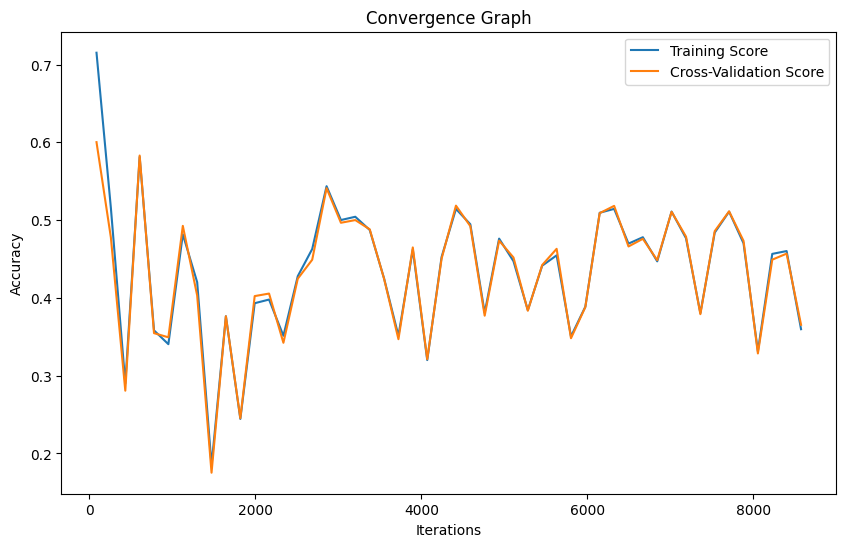

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph')
plt.legend(loc="best")
plt.show()